# Week 2: Supervised Techniques for Regression
## Boston Housing Assignment

 Scikit Learn documentation for this assignment:
 http://scikit-learn.org/stable/modules/model_evaluation.html 
 http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
 http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
 http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

 
 Textbook reference materials:
 Geron, A. 2017. Hands-On Machine Learning with Scikit-Learn
 and TensorFlow. Sebastopal, Calif.: O'Reilly. Chapter 3 Training Models
 has sections covering linear regression, polynomial regression,
 and regularized linear models. Sample code from the book is 
 available on GitHub at https://github.com/ageron/handson-ml


## Requirements for this assignment

    1) Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study.
    2) Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. 
    3) Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net.
    4) Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. 


Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

## Management problem:

Imagine that you are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management, and why?

# Discussion

After getting our data and libraries loaded in section A. Section B is dedicated to performing some exploratory data analysis. Some of data are transformed here to adjust the shape of the values relative to our dependant variable (log_MV). There were a few things I was aiming to do with this assignment the first was to evaluate the. The first was to imagine myself as a scientist with tranditional statistical approaches; EDA followed by selecting the most significant features, and contrast that to a modern machine learning route where the more impactful features are identified. The second was to evaluate the statistics generated by a few different methodologis (linear regression versus ElasticNet and linear regression versus lasso).

As for the first objective (section C) a subset of the columns were selected via exploratory analysis. Linear regression and elastic net are evaluated on the subset data. It is evident from the results below that these two methodologies produce very similar results in terms of coefficient estimates and term significance. To contrast this historical approach (section D), lasso regression was employed to identify the features which were most impactful. After the important features were identified, linear regression was used to contrast the results obtained from the lasso methodology. Again the results obtained were very similar interms of coefficients, error, and feature significance. Likewise as an additonal example a linear regression of all availble terms was conducted demonstrating the presence of overfitting of the model evidenced by the low significance of a number of terms. 

A key learning from this exercise is that machine learning outperforms more traditional approaches. For example when a scientist selects hypothesized impactful features they may have inherent bias because they lack the ability to see the data in the appropriate multidimensional space. Evaluating the data in a tranditional sense results in a model with a mean 8 fold CV RMSE score of ~0.22 in the scale of our dependant varaible. Conversely the most impactful features identified via lasso and subsequently evaluated with linear regression have an 8 fold CV RMSE score of ~0.21 allowing for a small reduction in the RMSE associated with the dependant variable improving our certainty and potentially allowing for larger profits with real estate investment by the firm. An additional learning is the power of lasso to downselect features for linear regression as the regularization methodology reduces the impact of the coefficient for a given feature to essentially zero. As such I would recommend this approach.

Within each regression section (with the exception of linear regression performed on all features; section D2) the following generally applies:
    


    1) The train and test data are split from the data of interest
    2) The model is fit on the training set using a pipeline
    3) Predictions are made on the traning set and a parity plot is generated of predictions vs observed values
    4) The training set is then passed to cross validation and RMSE is reported of each fold along with the average of all folds
    5) Addiitonal Summary statistics for the coefficients and overal model are generated - Training Statistics
    6) The model for the test set is fit using the same pipeline employed for the training set
    7) Predictions are made on the test set and a parity plot is generated of predictions vs observed values
    8) Addiitonal summary statistics for the coefficients and overal model are generated - Test Statistics


# A: Libraries and data read-in

In [52]:
RANDOM_SEED = 70

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
from math import sqrt  # for root mean-squared error calculation

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

#import from SKlearn
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

from scipy import stats

# read data for the Boston Housing Study
boston_input = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/boston.csv")

### Functions to yield information about the models

In [53]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
   # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
   # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

 
#This function print's statistics in a nice table format for linear regression
#requires the use of dataframe as inputs for all except the coefs arg.
def model_statistics(x_actual, y_actual, y_predict, coefs):

    matX = pd.DataFrame({"Constant":np.ones(len(x_actual))}).join(pd.DataFrame(x_actual.reset_index(drop=True)))
    MSE = (sum((y_actual-y_predict)**2))/(len(matX)-len(matX.columns))
    

    var_b = MSE*(np.linalg.inv(np.dot(matX.T,matX)).diagonal())
    
    sd_b = np.sqrt(var_b)
    ts_b = coefs/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(matX)-len(matX.columns)-1))) for i in ts_b]
    

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    coefs = np.round(coefs,4)

    SummaryDF = pd.DataFrame()
    SummaryDF["Coefficients"],SummaryDF["Standard Errors"],SummaryDF["t values"],SummaryDF["Probabilities"] = [coefs,sd_b,ts_b,p_values]

    return(SummaryDF)

# This is a function which returns the fomula of the model with it's coefficients
def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
        lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) 
        for coef, name in lst)


# B: Descriptive Stats and Dataframe inspect

In [54]:
# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
display(boston_input.head())
display(boston_input.tail())

print('\n\nGeneral description of the boston_input DataFrame:\n')
display(boston_input.info())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\n\nGeneral description of the boston DataFrame:\n')

display(boston.info())

print('\nDescriptive statistics of the boston DataFrame:\n')
display(boston.describe())


boston DataFrame (first and last five rows):


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0




General description of the boston_input DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   neighborhood  506 non-null    object 
 1   crim          506 non-null    float64
 2   zn            506 non-null    float64
 3   indus         506 non-null    float64
 4   chas          506 non-null    int64  
 5   nox           506 non-null    float64
 6   rooms         506 non-null    float64
 7   age           506 non-null    float64
 8   dis           506 non-null    float64
 9   rad           506 non-null    int64  
 10  tax           506 non-null    int64  
 11  ptratio       506 non-null    float64
 12  lstat         506 non-null    float64
 13  mv            506 non-null    float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.5+ KB


None



General description of the boston DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rooms    506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  mv       506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


None


Descriptive statistics of the boston DataFrame:



,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


array([[<AxesSubplot:title={'center':'crim'}>,
        <AxesSubplot:title={'center':'zn'}>,
        <AxesSubplot:title={'center':'indus'}>,
        <AxesSubplot:title={'center':'chas'}>],
       [<AxesSubplot:title={'center':'nox'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'dis'}>],
       [<AxesSubplot:title={'center':'rad'}>,
        <AxesSubplot:title={'center':'tax'}>,
        <AxesSubplot:title={'center':'ptratio'}>,
        <AxesSubplot:title={'center':'lstat'}>],
       [<AxesSubplot:title={'center':'mv'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

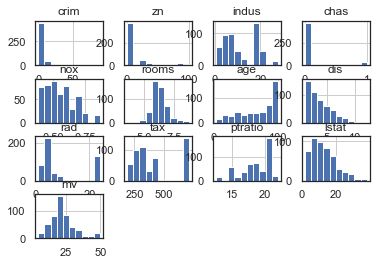

In [55]:
boston.hist()

## Correlation Heatmap

Text(0.5, 0.98, 'Correlation Heatmap for Boston')

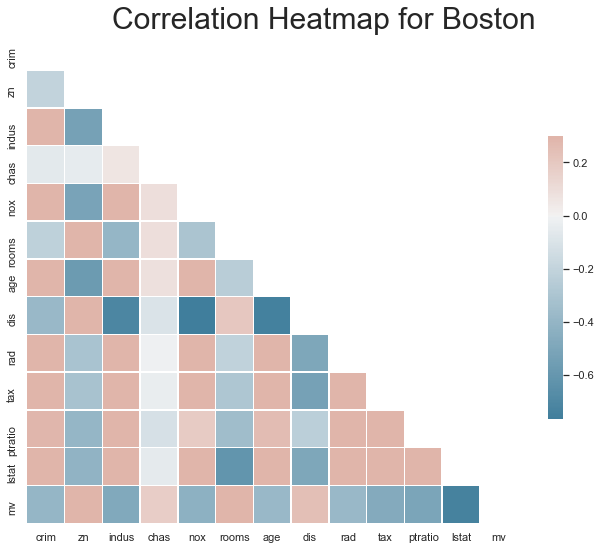

In [56]:
sns.set_theme(style="white")

#correlation matrix
corr =boston.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.subplots_adjust(top=1)
plt.suptitle("Correlation Heatmap for Boston",fontsize= 30)


<AxesSubplot:xlabel='ptratio', ylabel='tax'>

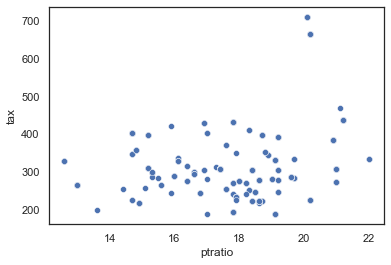

In [57]:
sns.scatterplot(boston.ptratio, boston.tax)

<AxesSubplot:xlabel='tax', ylabel='mv'>

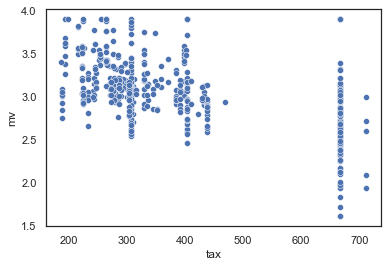

In [58]:
sns.scatterplot(boston.tax, np.log(boston.mv))


<AxesSubplot:>

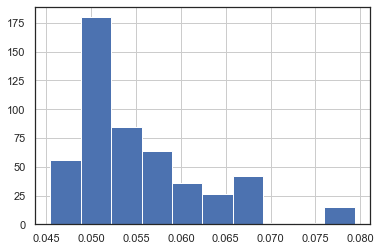

In [59]:
inv_ratio= 1/boston.ptratio
inv_ratio.hist()


<AxesSubplot:>

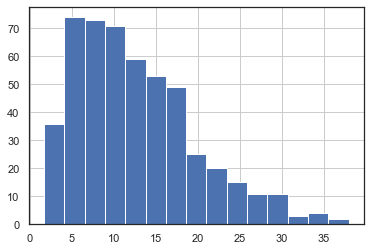

In [60]:
boston.lstat.hist(bins=15)

<AxesSubplot:>

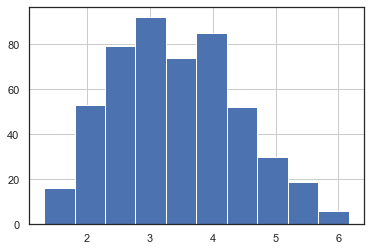

In [61]:
log = np.sqrt(boston.lstat)

log.hist()



<AxesSubplot:>

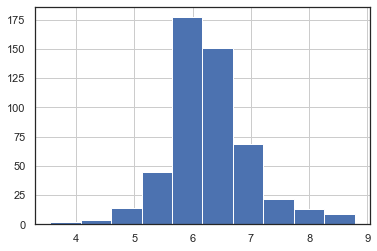

In [62]:
boston.rooms.hist()

<AxesSubplot:>

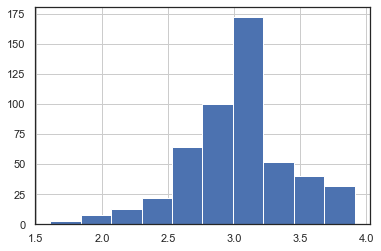

In [63]:
np.log(boston.mv).hist()

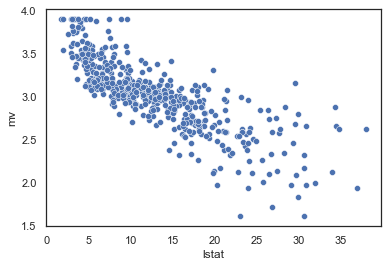

In [64]:
logplot = sns.scatterplot(y=np.log(boston.mv), x=boston.lstat)

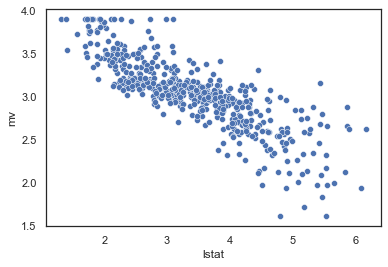

In [65]:
sqrtfeatureplot = sns.scatterplot(y=np.log(boston.mv), x= np.sqrt(boston.lstat))

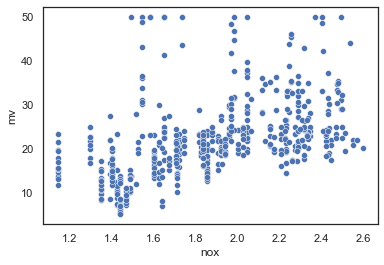

In [66]:
sqrtfeatureplot = sns.scatterplot(y=boston.mv, x= 1/boston.nox)


# C: Scientist's approach; select correlated features
## C1.) Data Preparation

In [67]:
boston_trimmed = boston[['mv', 'nox', 'lstat', 'ptratio', 'rooms', 'tax']]

boston_trimmed['sqrt_lstat'] = np.sqrt(boston_trimmed['lstat'])
boston_trimmed['log_MV']= np.log(boston_trimmed['mv'])

boston_trimmed.drop(['lstat', 'mv'], axis=1, inplace=True)


Text(0.5, 0.98, 'Correlation Heatmap for Boston_trimmed')

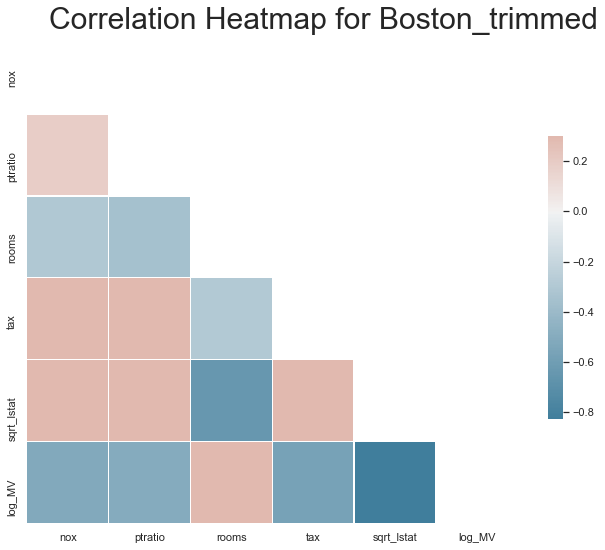

In [68]:
sns.set_theme(style="white")

#correlation matrix
corr =boston_trimmed.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.subplots_adjust(top=1)
plt.suptitle("Correlation Heatmap for Boston_trimmed",fontsize= 30)

### Here the scientist selects features sqrt_lstat, tax

In [69]:
# here is the data used in the scientist selected features
model_data =boston_trimmed[['log_MV','sqrt_lstat', 'tax']]

In [70]:
Trimmed_Train, Trimmed_Test = train_test_split(model_data, test_size = 0.2, random_state = RANDOM_SEED)

#separate features from labels

T_Test_y = Trimmed_Test['log_MV'].copy()
T_Test_X = Trimmed_Test.drop('log_MV', axis=1)

T_Train_y = Trimmed_Train['log_MV'].copy()
T_Train_X = Trimmed_Train.drop('log_MV', axis=1)




## C2.) Linear Regression of selected features

In [71]:
Linear_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
        ])

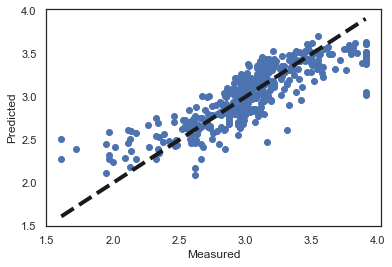

In [72]:
#fit our model
Linear_pipe.fit(T_Train_X, T_Train_y)

#predict the labels from the train values
Linear_T_train_pred = Linear_pipe.predict(T_Train_X)

#parity plot
fig, T_train = plt.subplots()
T_train.scatter(T_Train_y, Linear_T_train_pred)
T_train.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
T_train.set_xlabel('Measured')
T_train.set_ylabel('Predicted')

plt.show()


### Model Summary Stats (Linear Train)

In [73]:
#regression statistics functions
regression_results(T_Train_y, Linear_T_train_pred)

linear_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Train_X, y_actual=T_Train_y, y_predict=Linear_T_train_pred, coefs=linear_coefs)

explained_variance:  0.7111
r2:  0.7111
MAE:  0.1693
MSE:  0.0492
RMSE:  0.2219


,Coefficients,Standard Errors,t values,Probabilities
0,3.0281,0.040,74.894,0.0
1,-0.3057,0.013,-23.537,0.0
2,-0.0711,0.000,-927.715,0.0


### CrossValidation

In [74]:
#kfold construction
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

#get RMSE for the folds
cv_results = np.sqrt(-cross_val_score(Linear_pipe, T_Train_X, T_Train_y, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.21596483 0.2149933  0.22893011 0.20194299 0.22165648 0.21126178
 0.20771418 0.2781847 ]


0.22258104718229715

### Evaluate on Test

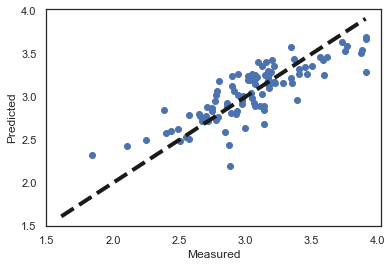

In [75]:
#fit our model on test data
Linear_pipe.fit(T_Test_X, T_Test_y)

#make predictions of the test labels
Linear_T_test_pred =Linear_pipe.predict(T_Test_X)

#parity plot
fig, Linear_test = plt.subplots()
Linear_test.scatter(T_Test_y, Linear_T_test_pred)
Linear_test.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
Linear_test.set_xlabel('Measured')
Linear_test.set_ylabel('Predicted')

plt.show()


### Model Summary Stats (Linear Test)

In [76]:
#our summary statistic functions
regression_results(T_Test_y, Linear_T_test_pred)

linear_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Test_X, y_actual=T_Test_y, y_predict=Linear_T_test_pred, coefs=linear_coefs)

explained_variance:  0.6838
r2:  0.6838
MAE:  0.1718
MSE:  0.0472
RMSE:  0.2173


,Coefficients,Standard Errors,t values,Probabilities
0,3.0600,0.082,37.176,0.0
1,-0.2891,0.031,-9.364,0.0
2,-0.0446,0.000,-255.687,0.0


## C3.) Scientist Approach ElasticNet Regression

In [77]:
Elastic_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ElasticNet(alpha=0.005, l1_ratio= 0.5))
        ])

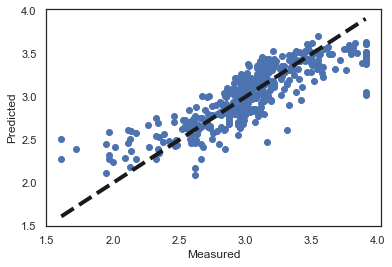

In [78]:
#fit model with EN on train
Elastic_pipe.fit(T_Train_X, T_Train_y)

#predict our outcomes of train
Elastic_T_train_pred = Elastic_pipe.predict(T_Train_X)

#parity plot
fig, Elastic_train = plt.subplots()
Elastic_train.scatter(T_Train_y, Linear_T_train_pred)
Elastic_train.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
Elastic_train.set_xlabel('Measured')
Elastic_train.set_ylabel('Predicted')

plt.show()

### ElasticNet Model Summary Stats (Train)

In [79]:
# Regression statistics functions again
regression_results(T_Train_y, Elastic_T_train_pred)

EN_coefs = np.append(Elastic_pipe.named_steps['regressor'].intercept_, Elastic_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Train_X, y_actual=T_Train_y, y_predict=Elastic_T_train_pred, coefs=EN_coefs)

explained_variance:  0.711
r2:  0.711
MAE:  0.169
MSE:  0.0493
RMSE:  0.2219


,Coefficients,Standard Errors,t values,Probabilities
0,3.0281,0.040,74.885,0.0
1,-0.3031,0.013,-23.337,0.0
2,-0.0698,0.000,-910.130,0.0


### Cross validation ElasticNet (Train)

In [80]:
# CrossValidation
cv_results = np.sqrt(-cross_val_score(Elastic_pipe, T_Train_X, T_Train_y, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.21644138 0.21492848 0.2293477  0.20123996 0.22188015 0.21209929
 0.20734617 0.27770334]


0.22262331025259058

### Evaluate on Test

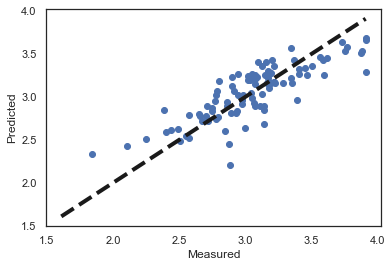

In [81]:
#fit the test data using EN
Elastic_pipe.fit(T_Test_X, T_Test_y)

#predict our test labels using EN
Elastic_T_test_pred = Elastic_pipe.predict(T_Test_X)

#pairty plot
fig, Elastic_test = plt.subplots()
Elastic_test.scatter(T_Test_y, Elastic_T_test_pred)
Elastic_test.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
Elastic_test.set_xlabel('Measured')
Elastic_test.set_ylabel('Predicted')

plt.show()



### ElasticNet model summary statistics (Test)

In [82]:
#our regression statistics again
regression_results(T_Test_y, Elastic_T_test_pred)

EN_coefs = np.append(Elastic_pipe.named_steps['regressor'].intercept_, Elastic_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Test_X, y_actual=T_Test_y, y_predict=Elastic_T_test_pred, coefs=EN_coefs)


explained_variance:  0.6838
r2:  0.6838
MAE:  0.1718
MSE:  0.0472
RMSE:  0.2173


,Coefficients,Standard Errors,t values,Probabilities
0,3.0600,0.082,37.171,0.0
1,-0.2865,0.031,-9.278,0.0
2,-0.0437,0.000,-250.333,0.0


# D. Machine Learning Approach
## D1.) Data Prep

In [83]:
#get our data back in order
boston_new =boston.copy()
boston_new['sqrt_lstat'] = np.sqrt(boston_new['lstat'])
boston_new['log_MV']= np.log(boston_new['mv'])

boston_new.drop(['lstat', 'mv'], axis=1, inplace=True)



In [84]:
# split our data now that we have all features again
Train, Test = train_test_split(boston_new, test_size = 0.2, random_state = RANDOM_SEED)

#separate features from labels for test
init_Test_Labels = Test['log_MV'].copy()
init_Test_Features = Test.drop('log_MV', axis=1)

#separate features from labels for train
init_y = Train['log_MV'].copy()
init_X = Train.drop('log_MV', axis=1)


## D2.) Lasso Regression on Train

In [85]:
lasso_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Lasso(alpha=0.1))
        ])

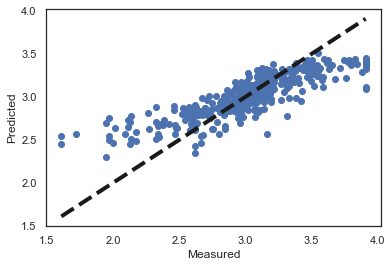

In [86]:
#fit our data using lasso
lasso_pipe.fit(init_X, init_y)
lasso_Xtrain_pred =lasso_pipe.predict(init_X)

#pairty plot
fig, Lasso_train = plt.subplots()
Lasso_train.scatter(init_y, lasso_Xtrain_pred)
Lasso_train.plot([init_y.min(), init_y.max()], [init_y.min(), init_y.max()], 'k--', lw=4)
Lasso_train.set_xlabel('Measured')
Lasso_train.set_ylabel('Predicted')

plt.show()



### Lasso Training Model Statistics

In [87]:
# regression statistics functions
regression_results(init_y, lasso_Xtrain_pred)

lasso_coefs = np.append(lasso_pipe.named_steps['regressor'].intercept_, lasso_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=init_X, y_actual=init_y, y_predict=lasso_Xtrain_pred, coefs=lasso_coefs)

explained_variance:  0.6527
r2:  0.6527
MAE:  0.1776
MSE:  0.0592
RMSE:  0.2433


,Coefficients,Standard Errors,t values,Probabilities
0,3.0281,0.300,10.088,0.000
1,-0.0230,0.002,-12.995,0.000
2,0.0000,0.001,0.000,1.000
3,-0.0000,0.003,-0.000,1.000
4,0.0000,0.049,0.000,1.000
5,-0.0000,0.229,-0.000,1.000
6,0.0075,0.025,0.297,0.767
7,-0.0000,0.001,-0.000,1.000
8,0.0000,0.012,0.000,1.000
9,-0.0000,0.004,-0.000,1.000


### Lasso impactful features
    most impactful features (in descending order) are: sqrt_lstat, crim, rooms, ptratio (this last one is pretty small

In [88]:
# Get our model formula
print ("Lasso model:", pretty_print_coefs(lasso_pipe.named_steps['regressor'].coef_))


Lasso model: -0.023 * X0 + 0.0 * X1 + -0.0 * X2 + 0.0 * X3 + -0.0 * X4 + 0.007 * X5 + -0.0 * X6 + 0.0 * X7 + -0.0 * X8 + -0.0 * X9 + -0.001 * X10 + -0.228 * X11


In [89]:
#corresponding features for the model formula
init_X.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'sqrt_lstat'],
      dtype='object')

Cross Validation of the train data using lasso

In [90]:
cv_results = np.sqrt(-cross_val_score(lasso_pipe, init_X, init_y, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.25392945 0.22979247 0.26218633 0.19805691 0.24525087 0.26674659
 0.22382093 0.28125463]


0.24512977394143415

### Lasso evaluation on test data

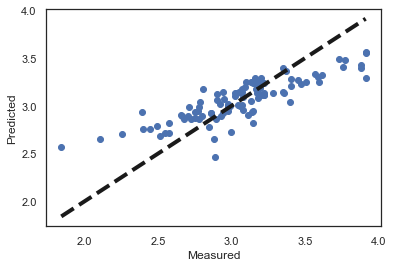

In [91]:
#fit lasso on test data
lasso_pipe.fit(init_Test_Features, init_Test_Labels)

#predict test labels using lasso
Lasso_test_pred = lasso_pipe.predict(init_Test_Features)

#parity plot
fig, Lasso_test = plt.subplots()
Lasso_test.scatter(init_Test_Labels, Lasso_test_pred)
Lasso_test.plot([init_Test_Labels.min(), init_Test_Labels.max()], [init_Test_Labels.min(), init_Test_Labels.max()], 'k--', lw=4)
Lasso_test.set_xlabel('Measured')
Lasso_test.set_ylabel('Predicted')

plt.show()


### Lasso Model Statistics (test)

In [92]:
# model statistics functions
lasso_Test_pred = lasso_pipe.predict(init_Test_Features)
regression_results(init_Test_Labels, lasso_Test_pred)

lasso_coefs = np.append(lasso_pipe.named_steps['regressor'].intercept_, lasso_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=init_Test_Features, y_actual=init_Test_Labels, y_predict=lasso_Test_pred, coefs=lasso_coefs)

explained_variance:  0.6408
r2:  0.6408
MAE:  0.1801
MSE:  0.0537
RMSE:  0.2316


,Coefficients,Standard Errors,t values,Probabilities
0,3.0600,0.611,5.010,0.000
1,-0.0000,0.007,-0.000,1.000
2,0.0000,0.002,0.000,1.000
3,-0.0000,0.010,-0.000,1.000
4,0.0000,0.123,0.000,1.000
5,-0.0000,0.447,-0.000,1.000
6,0.0125,0.051,0.244,0.808
7,-0.0000,0.002,-0.000,1.000
8,0.0000,0.024,0.000,1.000
9,-0.0000,0.010,-0.000,1.000


# D2.) LinearRegression

## D2a.) Linear Regression on Train (all features)

In [93]:
Linear_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
        ])

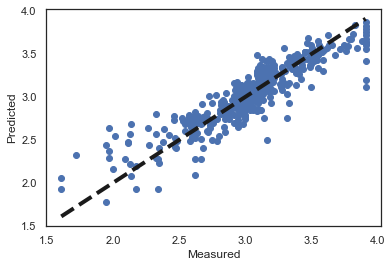

In [94]:
#fit all features with linear regressor
Linear_pipe.fit(init_X, init_y)

#predict labels on all features 
Linear_Xsub_train_pred =Linear_pipe.predict(init_X)

#parity plot
fig, Lin_train = plt.subplots()
Lin_train.scatter(init_y, Linear_Xsub_train_pred)
Lin_train.plot([init_y.min(), init_y.max()], [init_y.min(), init_y.max()], 'k--', lw=4)
Lin_train.set_xlabel('Measured')
Lin_train.set_ylabel('Predicted')

plt.show()

### Linear Regression Statistics (all features)

In [95]:
# model statistics functions
regression_results(init_y, Linear_Xsub_train_pred)

sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)

model_statistics(x_actual= init_X, y_actual= init_y, y_predict=Linear_Xsub_train_pred, coefs=sub_coefs)

explained_variance:  0.806
r2:  0.806
MAE:  0.1345
MSE:  0.0331
RMSE:  0.1818


,Coefficients,Standard Errors,t values,Probabilities
0,3.0281,0.224,13.499,0.000
1,-0.1039,0.001,-78.726,0.000
2,0.0192,0.001,31.629,0.000
3,0.0047,0.003,1.835,0.067
4,0.0264,0.037,0.717,0.474
5,-0.0924,0.171,-0.539,0.590
6,0.0363,0.019,1.923,0.055
7,0.0284,0.001,48.583,0.000
8,-0.1065,0.009,-12.134,0.000
9,0.1098,0.003,39.379,0.000


## From this we can see that R2 is higher (RMSE also lower) for linear regression. 
    1) However, there are insignificant terms in our model indicated by low t-stats and high p-values in the summary table above.
    2) The regularization of the lasso regressior penalizes the contribution of those coefficients such that it sets them to zero.
    
### Let's use the most prominant features from lasso regression (those with the largest coefficients) for our linear regression

## D2b.) Linear Regression with lasso downselected features

In [96]:
boston_subset = Train[['sqrt_lstat', 'crim' , 'rooms', 'log_MV']]

X_sub = boston_subset.iloc[:,0:3]
y_sub = boston_subset.iloc[:,-1]

X_sub.columns

Index(['sqrt_lstat', 'crim', 'rooms'], dtype='object')

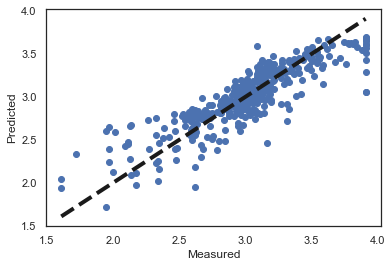

In [97]:
Linear_pipe.fit(X_sub, y_sub)

Linear_Xsub_train_pred =Linear_pipe.predict(X_sub)

fig, train = plt.subplots()
train.scatter(y_sub, Linear_Xsub_train_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
train.plot([y_sub.min(), y_sub.max()], [y_sub.min(), y_sub.max()], 'k--', lw=4)
train.set_xlabel('Measured')
train.set_ylabel('Predicted')

plt.show()

### Downselected Linear Regression model statistics

In [98]:
regression_results(y_sub,Linear_Xsub_train_pred)
sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual= X_sub, y_actual= y_sub, y_predict=Linear_Xsub_train_pred, coefs=sub_coefs)

explained_variance:  0.7501
r2:  0.7501
MAE:  0.1547
MSE:  0.0426
RMSE:  0.2064


,Coefficients,Standard Errors,t values,Probabilities
0,3.0281,0.158,19.205,0.0
1,-0.2535,0.015,-17.432,0.0
2,-0.0973,0.001,-78.051,0.0
3,0.0746,0.020,3.827,0.0


In [99]:
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

#get RMSE for the folds
cv_results = np.sqrt(-cross_val_score(Linear_pipe, X_sub, y_sub, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.1956412  0.19138373 0.18641936 0.20414589 0.21712292 0.20314577
 0.19676124 0.27244515]


0.20838315786020906

## implement the identified feature downselect for linear regression on the test data

In [100]:
Test_subset = Test[['sqrt_lstat', 'crim' , 'rooms','log_MV']]
Test_X_sub = Test_subset.iloc[:,0:3]
Test_y_sub = Test_subset.iloc[:,-1]


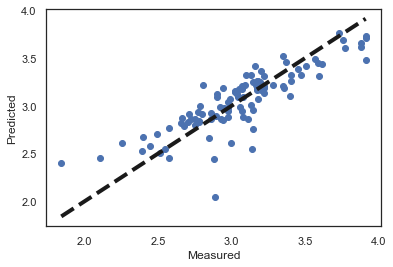

In [101]:
Linear_pipe.fit(Test_X_sub, Test_y_sub)

Linear_Xsub_test_pred =Linear_pipe.predict(Test_X_sub)

fig, Test_ln = plt.subplots()
Test_ln.scatter(Test_y_sub, Linear_Xsub_test_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Test_ln.plot([Test_y_sub.min(), Test_y_sub.max()], [Test_y_sub.min(), Test_y_sub.max()], 'k--', lw=4)
Test_ln.set_xlabel('Measured')
Test_ln.set_ylabel('Predicted')

plt.show()

### Summary Statistis for downselected linear regression (test)

In [102]:
### Noregression_results(y_sub,Linear_Xsub_train_pred)
regression_results(Test_y_sub,Linear_Xsub_test_pred)
test_sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual= Test_X_sub, y_actual= Test_y_sub, y_predict=Linear_Xsub_test_pred, coefs=test_sub_coefs)

explained_variance:  0.719
r2:  0.719
MAE:  0.1546
MSE:  0.042
RMSE:  0.2049


,Coefficients,Standard Errors,t values,Probabilities
0,3.0600,0.328,9.339,0.000
1,-0.2240,0.034,-6.496,0.000
2,-0.0660,0.004,-15.362,0.000
3,0.0918,0.038,2.399,0.018
